안녕하세요, 이번 포스팅에서는 Word2Vec을 직접 구현해보도록 하겠습니다. 
저번포스팅에서 예고했듯 Word2Vec 중에서도 Skip-gram 모델을 구현하였고 Negative sampling 기법도 적용해보았습니다.

이론적인 배경이 부족하신 분들은 이전 포스팅들(Word2Vec 1,2편)을 참고해주시면 감사하겠습니다.

전체 골격은 아래와 같으며, Main code를 제외한 부분들은 모두 모듈화 한 후 Main code에서 간단하게 실행할 수 있도록 구성했습니다.  
각 파트별로 하나씩 살펴 보도록 하겠습니다.

## Skeleton

- 한국어 텍스트 전처리
- Input / label pair 생성 (Negative sampling 포함)
- Training
- T-SNE를 이용한 저차원 투영 및 시각화
- Main code

## 1. 한국어 전처리
 
먼저, 예제 문장이 한국어로 이루어져 있기 때문에 한국어 전처리를 진행해줍니다.  
한국어는 접두사, 조사, 동사의 변형 등의 이유로 영어에 비해 난이도가 훨씬 높지만, 한국어를 이용한 임베딩을 해보고 싶었습니다.  
전처리 기법은 깊이 들어가면 너무 난이도가 높아지므로 Corpus도 최대한 간결하게 준비했습니다.

한국어 전처리 라이브러리 중에서도 문장 분리를 도와주는 kss와 형태소 분석을 도와주는 Mecab, 정규표현식 라이브러리인 re를 사용했습니다.  
정규표현식을 이용하여 이번에 사용한 Corpus에는 해당사항이 없지만 몇 가지 경우에 대한 처리를 예시로 적어보았습니다.

In [1]:
import kss
import re
from konlpy.tag import Mecab

class Prep():
        
    def Clean_text(self, text): # noisy한 문장을 cleaning
        self.sentences = []
        
        for i in range(len(text)):
            if (i+1) % 10 == 0:
                print(str(i+1) + 'th sentence is spliting...')
        
            temp = re.sub("[^가-힣a-z0-9.?]", ' ', text[i]) #한글, 영어, 숫자, 온점, 물음표가 아닌 것을 공백으로 삭제
            temp = re.sub("[.]{2,}", ".", temp) # 반복되는 온점 (...) 삭제
            temp = re.sub("[?]{2,}", "?", temp) # 반복되는 물음표 (?) 삭제
            temp = re.sub("[!]{2,}", "!", temp) # 반복되는 느낌표 (!) 삭제
            temp = re.sub("[' ']{2,}", " ", temp) # 반복되는 공백 삭제 
            temp = kss.split_sentences(temp)  #문장 분리

            for tmp in temp:
                self.sentences.append(tmp)
        
        return self.sentences

        
    def Tokenizer(self, sentences): # cleaned data에 대한 형태소 분석 후 vocabulary 구축
        
        self.corpus = []
        self.words = []
        self.vocab = []
        
        tokenizer = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        
        for sent in self.sentences:
            temp = tokenizer.morphs(sent)
            self.corpus.append(temp)
            
            for tmp in temp:
                self.words.append(tmp)

        self.vocab = set(self.words)
        
        return self.corpus, self.words, self.vocab
    
    def Make_dict(self,vocab): # 만들어진 Vocabulary를 기준으로 단어-정수 및 정수-단어 인덱싱 dictionary 생성
        self.word_dict = {w: i for i, w in enumerate(vocab)}
        self.index_dict = {i: w for i, w in enumerate(vocab)}
        return self.word_dict, self.index_dict 
    
    def Get_clean(self, text): #위의 세가지 메소드를 한번에 진행                
        sentences =  self.Clean_text(text)
        corpus, words, vocab = self.Tokenizer(sentences)
        word_dict, index_dict = self.Make_dict(vocab)
        
        return sentences, corpus, words, vocab, word_dict, index_dict

## 2. Input / label pair 생성 (Negative sampling 포함)

Input, target,label을 뽑아주는 클래스를 정의했습니다.  
초기 파라미터 설정에서 Negative sampling에 필요한 확률분포를 정의해 주었습니다.  
지수는 선행 연구들에서 가장 성능이 좋다고 알려져 있는 3/4로 설정했습니다.  

다음으로, Negative Sampling을 기반으로 각 input, target,label을 생성해 주었습니다.  
Draw 함수를 통해 negative sampling의 확률 분포에 따라 n_negsam개의 sample을 뽑도록 설정했습니다(n_negsam은 원 논문에서 k와 같습니다.)

Negative sampling은 중심단어에 대한 주변 단어는 반드시 포함하고, 주변단어가 아닌 단어들을 추가적으로 샘플링하는 기법입니다.  
Window size가 2일 경우 문장길이가 충분하고 center word가 중앙에 위치하면 context word는 4개가 되지만, center word가 문장의 가장 앞쪽이나 뒤쪽에 있을때는 2개가 됩니다.   

이런 경우를 해결하기 위해 context word가 부족할경우 추가로 샘플링을 하여 최종적으로는 총 (2 x window size) + negsam 개의 target words가 생성되도록 했습니다.

In [2]:
class Make_pairs(): # Input과 target, label을 만들어주는 클래스
    
    def __init__(self):
        
        from collections import defaultdict
        self.inputs = [] 
        self.targets = []
        self.labels = []
        
        # Negative sampling 정의
        self.wordFreq = defaultdict(int)
        for word in words:
            self.wordFreq[word] += 1
        
        self.SumFreq = sum([freq**(3/4) for freq in self.wordFreq.values()]) # 분모
        self.wordProb = {word:((freq**(3/4))/self.SumFreq) for word, freq in self.wordFreq.items()} #샘플링 확률분포
        
    def Draw(self,n_sample): # n_sample : sample을 몇 개를 뽑을건지?
        negsam = []
        for i in range(n_sample):
            negsam.append(np.random.choice(list(self.wordProb.keys()), p=list(self.wordProb.values()))) #확률분포 P에 따른 추출
        
        return negsam
    
    def Get_pairs(self, window_size, n_negsam):
        for c in corpus: # for each sentence          
            for idx in range(len(c)): # for each idx
                start = max(0,idx - window_size)
                tail = min(idx + window_size, len(c)-1)
            
                #add negative samples to context
                context = c[start:idx] + c[idx+1:tail+1]
                needed_negsam = 2*window_size+n_negsam - len(context) # needed number of negative samples
                negsam = self.Draw(needed_negsam) # draw negative samples
            
                #stack pairs
                self.inputs.append(c[idx])
                self.targets.append(context+negsam)
                self.labels.append([1]*len(context) + [0]*needed_negsam)
                  
        return self.inputs, self.targets, self.labels   

## 3. Training

필요한 재료들이 준비 되었으니 이제 훈련을 시켜 봅시다. 
간단한 구현을 위해 batch size = 1인 SGD 방식으로 구현했습니다. 

torch.autograd의 Variable을 이용하였고, requires_grad=True로 선언하여 backward()로 초기 가중치까지 모두 gradient를 계산할 수 있습니다.  

center_mat과 context_mat은 각각 Input과 projection layer를 연결해주는 $W$ matrix와 projection과 output layer를 연결해주는 $W'$ matrix이며, 차원은 $(H,V)$, $(V,H)$ 입니다. 

$H$는 임베딩 차원 수를 의미하며, $V$는 unique한 vocabulary의 size를 의미합니다. 차원을 거꾸로 설정한 이유는 이후 torch.matmul을 이용한 계산 시 더욱 직관적으로 편리하게 계산하기 위함입니다. 

각 matrix는 Xavier 초기화를 적용했습니다.

Negative sampling의 목적은 전체 vocabulary에 대한 loss를 구했을 때의 연산량을 줄이기 위해 일부 샘플링에 대한 loss를 구하는 것이란 것을 기억하실겁니다.

각 샘플링된 타겟 벡터에 대한 loss와 gradient만 반영하기 위해서, context_mat에서 target index를 이용하여 target vector들만 추출한 후 context_tmp라는 Variable으로 정의했습니다. context_tmp를 이용하여 loss와 gradient를 구한 후, 해당 값을 context_mat에 반영해주었습니다. 

In [3]:
from torch.autograd import Variable
def train(inputs, targets, labels, emb_dim, lr, n_epoch):
    
    vocab_size = len(vocab)
    target_size = len(targets[0])
    center_mat = Variable(torch.nn.init.xavier_normal_(torch.empty(emb_dim, vocab_size)),requires_grad=True).float() # W mat
    context_mat = Variable(torch.nn.init.xavier_normal_(torch.empty(vocab_size, emb_dim)),requires_grad=True).float() # W' mat
    
    for epoch in range(n_epoch): 
        loss_value = 0
        for batch in range(len(inputs)): 
            x = word_dict[inputs[batch]] # word index of input
            h = center_mat[:,x] # look-up table
            
            tar_ind = [word_dict[tar] for tar in targets[batch]]  # make target index
                
            context_tmp = Variable(context_mat[tar_ind,:], requires_grad=True).float() # embedded target vectors
            z = torch.matmul(context_tmp,h) 
            y = torch.LongTensor(labels[batch])

            y_hat = F.log_softmax(z, dim=0)
            loss = F.nll_loss(y_hat, y)
            loss_value += loss.item()
            loss.backward()
            
            center_mat.data -= lr * center_mat.grad.data # update center_mat
            context_mat.data[tar_ind,:] -= lr * context_tmp.grad.data # update context_mat with context_tmp
            
            # initialize gradient after update
            center_mat.grad.data.zero_() 
            context_tmp.grad.data.zero_()
        
        if epoch % 100 == 0:
            print(f"Loss at this epoch {epoch+100}: {loss_value / vocab_size}")
        
    return center_mat         

## 4. T-SNE를 이용한 저차원 투영

학습이 완료된 임베딩 벡터들은 H차원의 벡터들입니다.  
이를 효과적으로 시각화하기 위해서는 2차원 평면에 뿌리는 것이 좋습니다.

따라서 H차원의 벡터를 2차원의 평면상에 투영해야합니다.  
단순히 PCA를 사용하게 되면 2차원 평면상에서 벡터들이 뭉개질 우려가 있으므로, 각 벡터의 유사성이 저차원에서도 유사하도록 보존할 수 있는 T-SNE를 사용하였습니다.


In [4]:
def TSNEplot(wordvec, vocab, perplexity):
    
    #matplotlib 패키지 한글 깨짐 처리
    import matplotlib.pyplot as plt
    %matplotlib notebook
    plt.rc('font', family='Malgun Gothic') #윈도우, 구글 콜랩
    plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

    from sklearn.manifold import TSNE
    
    wordvec_2d = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='random').fit_transform(wordvec)
    plt.scatter(wordvec_2d[:,0], wordvec_2d[:,1], s=0.5)

    test_words=[]
    for i in range(len(vocab)):
        test_words.append(index_dict[i])
    
    for i, word in enumerate(test_words):
        plt.annotate(word, xy=(wordvec_2d[i, 0], wordvec_2d[i, 1]))
    
    return wordvec_2d    

## 5. Main code

데이터 전처리부터 학습, 시각화까지 모두 모듈화를 시켜 두었으므로 Main code에서는 간단한 파라미터와 예제 문장만 입력하여 간단히 모델을 실행시킬 수 있습니다.

Loss at this epoch 100: 4.244018190785458
Loss at this epoch 200: 1.7980029598662728
Loss at this epoch 300: 1.8000573233554238
Loss at this epoch 400: 1.7875694193338092
Loss at this epoch 500: 1.7586927178658938
Loss at this epoch 600: 1.7593185682045787
Loss at this epoch 700: 1.756637548145495
Loss at this epoch 800: 1.7313925749377201
Loss at this epoch 900: 1.710316234513333
Loss at this epoch 1000: 1.7003323239715475


<IPython.core.display.Javascript object>


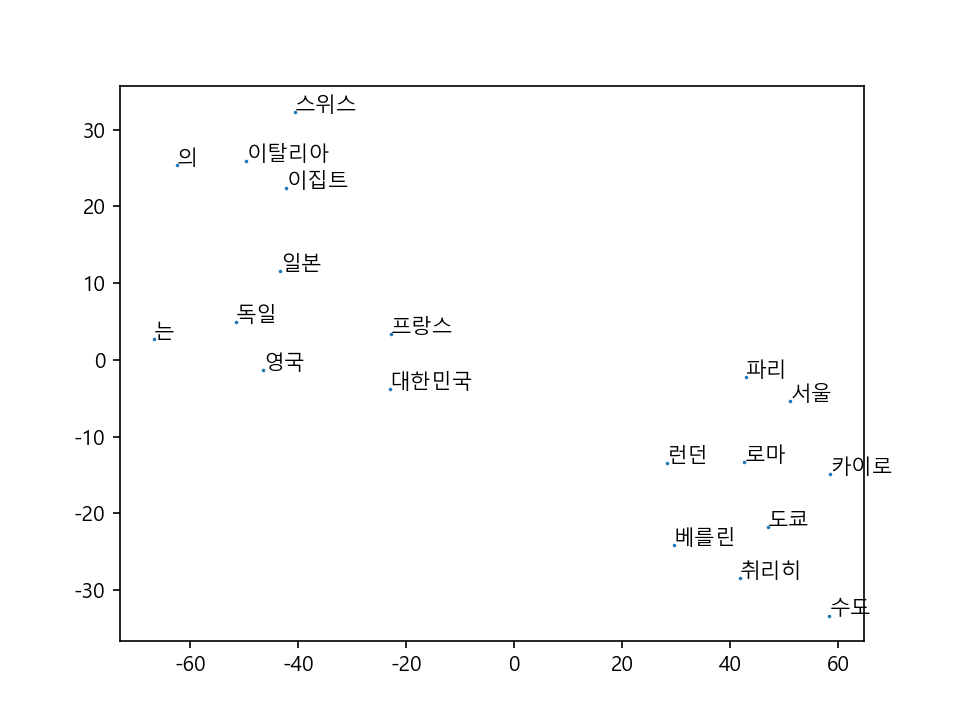

In [11]:
# Library import
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# 간단한 Corpus
text = ['대한민국의 수도는 서울',
       '독일의 수도는 베를린',
       '프랑스의 수도는 파리',
       '스위스의 수도는 취리히',
       '일본의 수도는 도쿄',
       '이탈리아의 수도는 로마',
       '영국의 수도는 런던',
       '이집트의 수도는 카이로'
       ]        

#parameters
emb_dim = 20
window_size = 2
n_negsam = 3
lr = 0.01
n_epoch = 1000

sentences, corpus, words, vocab, word_dict, index_dict = Prep().Get_clean(text) # 전처리
inputs, targets, labels = Make_pairs().Get_pairs(window_size, n_negsam) # Input / target / label 생성
center_mat = train(inputs, targets, labels, emb_dim, lr, n_epoch) # Training
wordvec_2d = TSNEplot(center_mat.data.T, vocab, perplexity=5) # TNSE plotting